# Single Shot Multiple Box Detector (SSD) for Object Detection for Self driving Cars

In [1]:
# adding path, so the keras ssd packages can be used
import sys
sys.path.append('../input/keras-ssd/')

In [21]:
# imports 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

In [3]:
# imports for training the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

In [4]:
# setting the image labels and parameters for the dataset generators 
img_height = 300
img_width = 480
img_channels = 3

intensity_mean = 127.5
intensity_range = 127.5

n_classes = 5
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

In [5]:
# building the model with the parameters, so the transfer learning can be performed
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

In [7]:
# Initializing the dataset generators
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [8]:
# setting the directories for the dataset generators
images_dir = '../input/self-driving-cars/images/'

train_labels_filename = '../input/self-driving-cars/labels_train.csv'
val_labels_filename   = '../input/self-driving-cars//labels_val.csv'

In [9]:
# parsing training and test dataset labels from csv
train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [10]:
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [11]:
# Data augmentation generator to efficiently use the images for training
batch_size = 1

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

In [12]:
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

In [13]:
# The pre-trained SSD model to be used for performing transfer learning
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

In [14]:
# Training and validation generators
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [15]:
# load the model pre-trained model for fine tuning
model_checkpoint = ModelCheckpoint(filepath='ssd7_weights.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             early_stopping,
             reduce_learning_rate]

# Hyperparameter tuning

In [44]:
# The method to train the individual model for tuning
tunable_models = {}
model_histories = {}
def train(params, model_name=""):
    
    print("Training Model:", model_name,"with hyperparameters ", params)
    
    initial_epoch   = 0
    final_epoch     = params["epochs"]
    steps_per_epoch = 20

    K.clear_session()
    tunable_model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)
    
    if params["optimizer"] == "adam":
        selected_optimizer = Adam(lr = params["learning_rate"], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    elif params["optimizer"] == "rms":
        selected_optimizer = RMSprop(lr = params["learning_rate"], rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    tunable_model.compile(optimizer=selected_optimizer, loss=ssd_loss.compute_loss)
    
    history = tunable_model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=final_epoch,
                                callbacks=callbacks,
                                validation_data=val_generator,
                                validation_steps=ceil(val_dataset_size/batch_size
                                                     ),
                                initial_epoch=initial_epoch)

    model.save('model_' + model_name + ' .h5')
    if model_name in tunable_models:
        tunable_models[model_name].append(model)
        model_histories[model_name].append(history)
    else:
        tunable_models[model_name] = [model]
        model_histories[model_name] = [history]
        
    return model

In [45]:
# hyperparameters grid, starting the tuning process
model_idx = 0
hyperparameters_to_try = {"optimizer": ["adam", "rms"], "learning_rate": [0.001, 0.01]}
for hyperparam_combo in list(ParameterGrid(hyperparameters_to_try)):
    hyperparam_combo["epochs"] = 5
    train(hyperparam_combo, model_name="model_" + str(model_idx))
    model_idx += 1

Training Model: model_0 with hyperparameters  {'learning_rate': 0.001, 'optimizer': 'adam', 'epochs': 5}
Epoch 1/5
19/20 [===========================>..] - ETA: 0s - loss: 0.4037
Epoch 00001: val_loss did not improve from 0.00455
20/20 [==============================] - 63s 3s/step - loss: 0.3992 - val_loss: 0.3055 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.2436
Epoch 00002: val_loss did not improve from 0.00455
20/20 [==============================] - 63s 3s/step - loss: 0.2436 - val_loss: 0.1857 - lr: 0.0010
Epoch 3/5
19/20 [===========================>..] - ETA: 0s - loss: 0.1500
Epoch 00003: val_loss did not improve from 0.00455
20/20 [==============================] - 63s 3s/step - loss: 0.1483 - val_loss: 0.1134 - lr: 0.0010
Epoch 4/5
19/20 [===========================>..] - ETA: 0s - loss: 0.0921
Epoch 00004: val_loss did not improve from 0.00455
20/20 [==============================] - 61s 3s/step - loss: 0.0910 - val_loss: 0.0701 - lr: 0.

In [46]:
print(model_histories)

{'model_0': [<tensorflow.python.keras.callbacks.History object at 0x7fafc9fb7310>], 'model_1': [<tensorflow.python.keras.callbacks.History object at 0x7fafa94bc990>], 'model_2': [<tensorflow.python.keras.callbacks.History object at 0x7fafd064b410>], 'model_3': [<tensorflow.python.keras.callbacks.History object at 0x7fafc81b3cd0>]}


Text(0.5, 1.0, 'Model with learning_rat 0.001 and Adam optimizer')

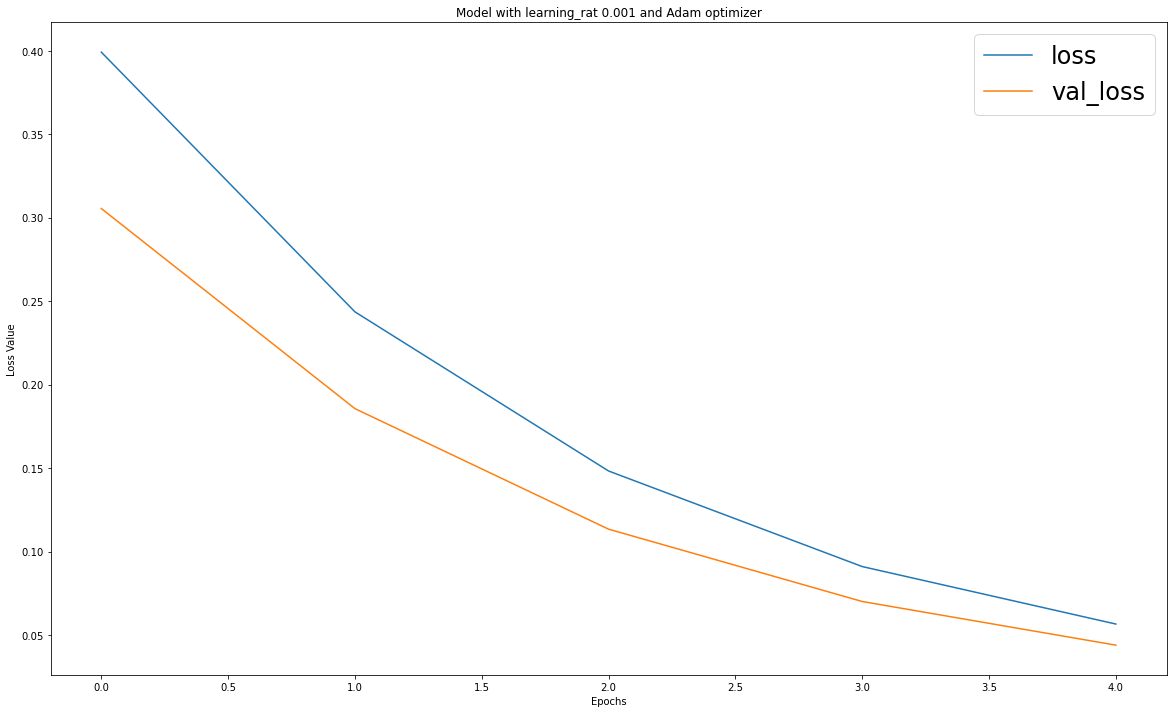

In [49]:
plt.figure(figsize=(20,12))
plt.plot(model_histories["model_0"][0].history['loss'], label='loss')
plt.plot(model_histories["model_0"][0].history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper right', prop={'size': 24})
plt.title("Model with learning_rat 0.001 and Adam optimizer")

Text(0.5, 1.0, 'Model with learning_rat 0.001 and RMS optimizer')

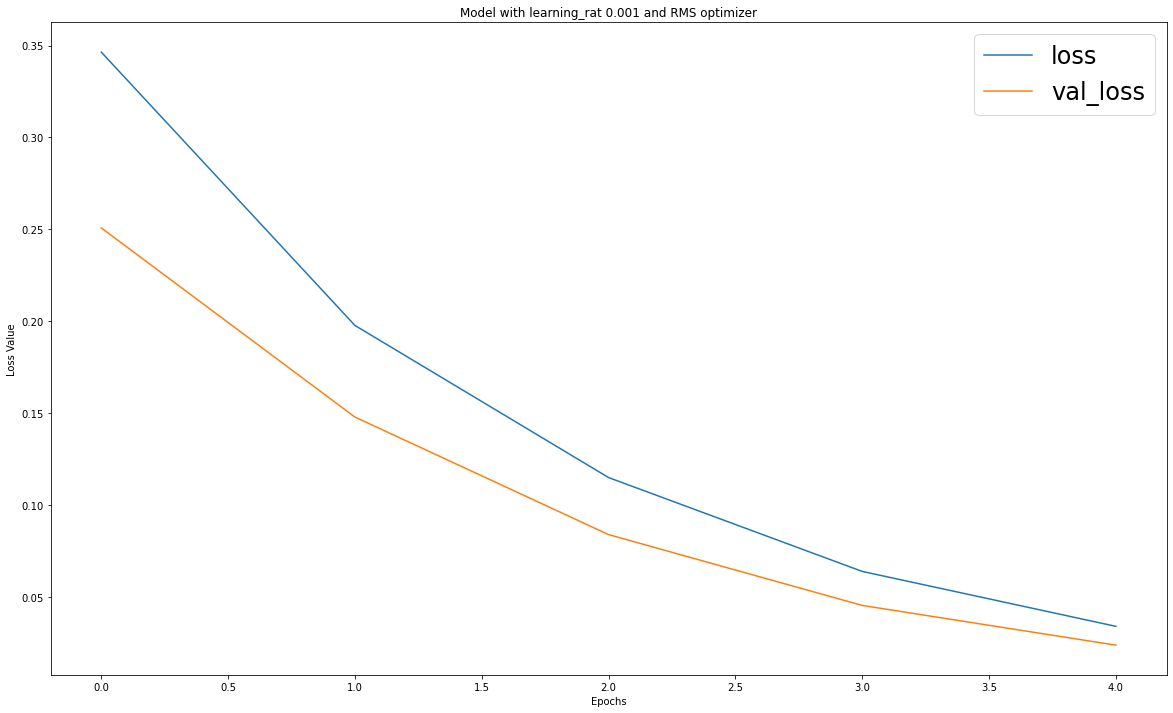

In [50]:
plt.figure(figsize=(20,12))
plt.plot(model_histories["model_1"][0].history['loss'], label='loss')
plt.plot(model_histories["model_1"][0].history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper right', prop={'size': 24})
plt.title("Model with learning_rat 0.001 and RMS optimizer")

Text(0.5, 1.0, 'Model with learning_rat 0.01 and Adam optimizer')

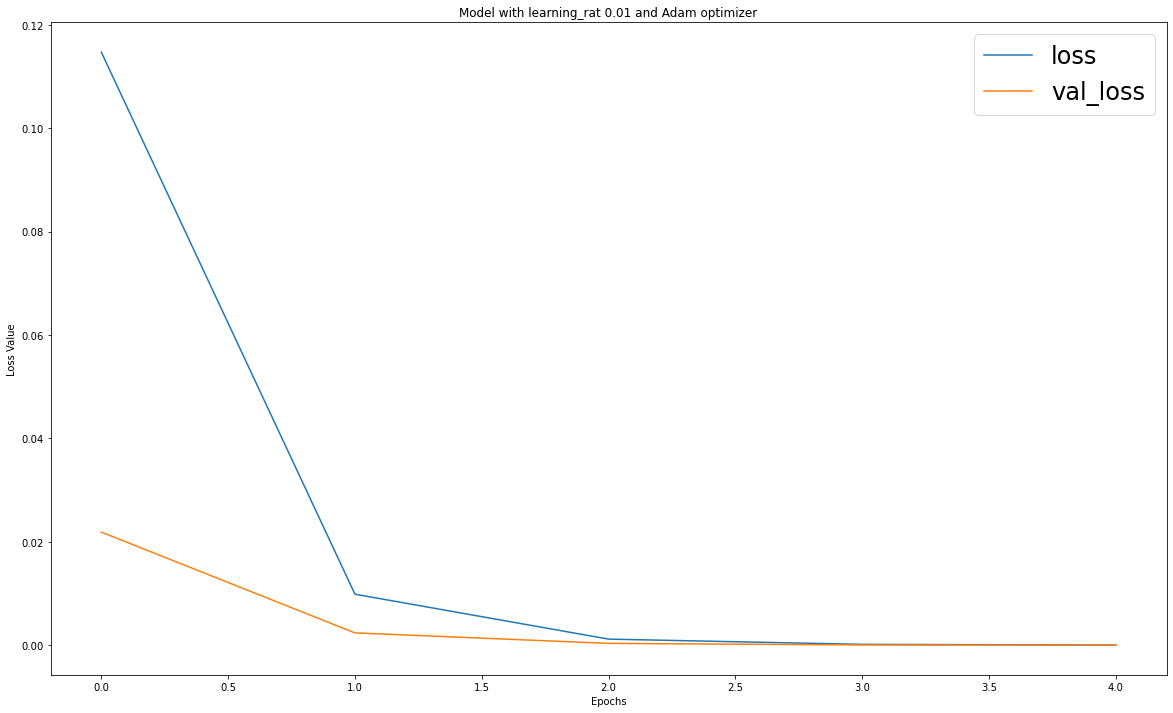

In [51]:
plt.figure(figsize=(20,12))
plt.plot(model_histories["model_2"][0].history['loss'], label='loss')
plt.plot(model_histories["model_2"][0].history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper right', prop={'size': 24})
plt.title("Model with learning_rat 0.01 and Adam optimizer")

Text(0.5, 1.0, 'Model with learning_rat 0.01 and RMS optimizer')

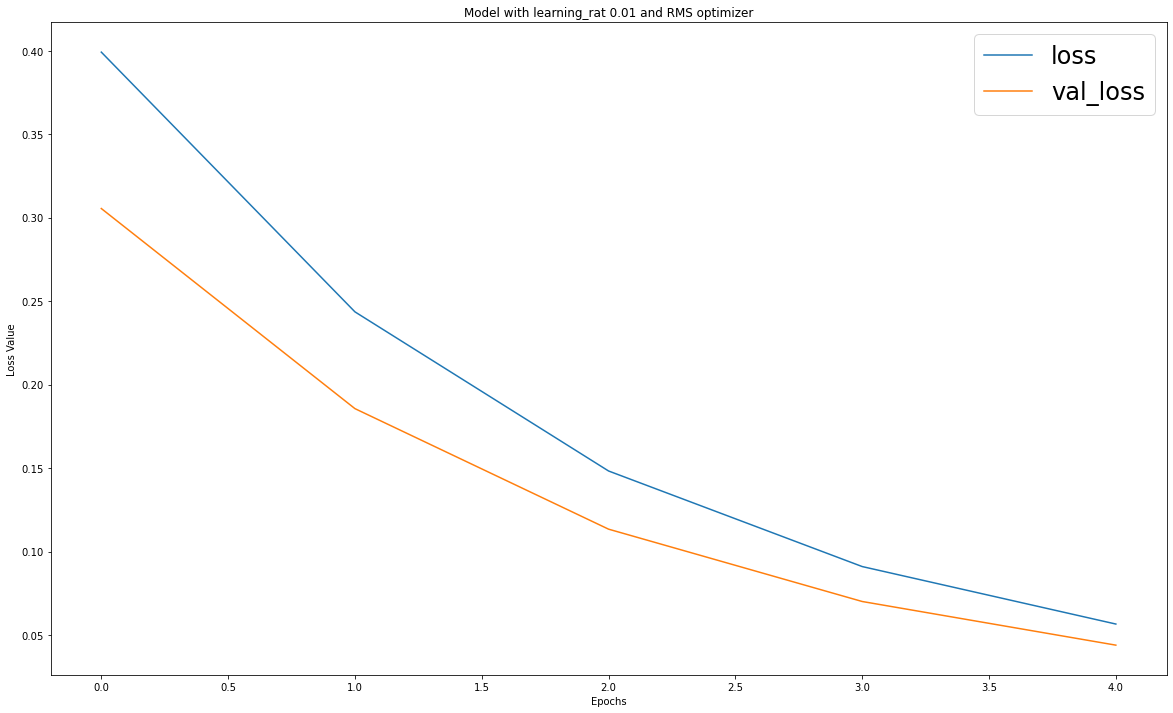

In [52]:
plt.figure(figsize=(20,12))
plt.plot(model_histories["model_0"][0].history['loss'], label='loss')
plt.plot(model_histories["model_0"][0].history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper right', prop={'size': 24})
plt.title("Model with learning_rat 0.01 and RMS optimizer")

# Predictions

In [53]:
predict_generator = val_dataset.generate(batch_size=6,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [54]:
batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])
print(len(batch_filenames))

Image: ../input/self-driving-cars/images/1478901447838338922.jpg

Ground truth boxes:

[[  1 106 150 150 170]
 [  1 207 151 221 161]
 [  1 232 142 252 160]
 [  1 234 147 250 161]
 [  1 321 138 375 172]
 [  1 379 139 440 170]]
6


In [55]:
# All Models
tunable_models

{'model_0': [<tensorflow.python.keras.engine.training.Model at 0x7fb3af93d4d0>],
 'model_1': [<tensorflow.python.keras.engine.training.Model at 0x7fb3af93d4d0>],
 'model_2': [<tensorflow.python.keras.engine.training.Model at 0x7fb3af93d4d0>],
 'model_3': [<tensorflow.python.keras.engine.training.Model at 0x7fb3af93d4d0>]}

In [57]:
y_pred = tunable_models["model_0"][0].predict(batch_images)

In [58]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred * 266.,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

../input/keras-ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
../input/keras-ssd/ssd_encoder_decoder/ssd_output_decoder.py:176: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-2,-1]] *= y_pred[:,:,[-6,-5]] # (w(pred) / w(anchor)) * w(anchor) == w(pred), (h(pred) / h(anchor)) * h(anchor) == h(pred)
../input/keras-ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
../input/keras-ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 1.00e+00  4.43e+01  9.35e+05 -2.63e+15  9.35e+05  2.63e+15]
 [ 1.00e+00  4.43e+01  9.31e+05 -2.64e+15  9.31e+05  2.64e+15]
 [ 1.00e+00  4.43e+01  9.26e+05 -2.64e+15  9.26e+05  2.64e+15]
 ...
 [ 3.00e+00  4.54e+01 -1.15e+08      -inf -1.15e+08       inf]
 [ 2.00e+00  4.57e+01      -inf      -inf       inf       inf]
 [ 2.00e+00  4.56e+01  4.89e+06 -3.40e+07  4.89e+06 -3.40e+07]]


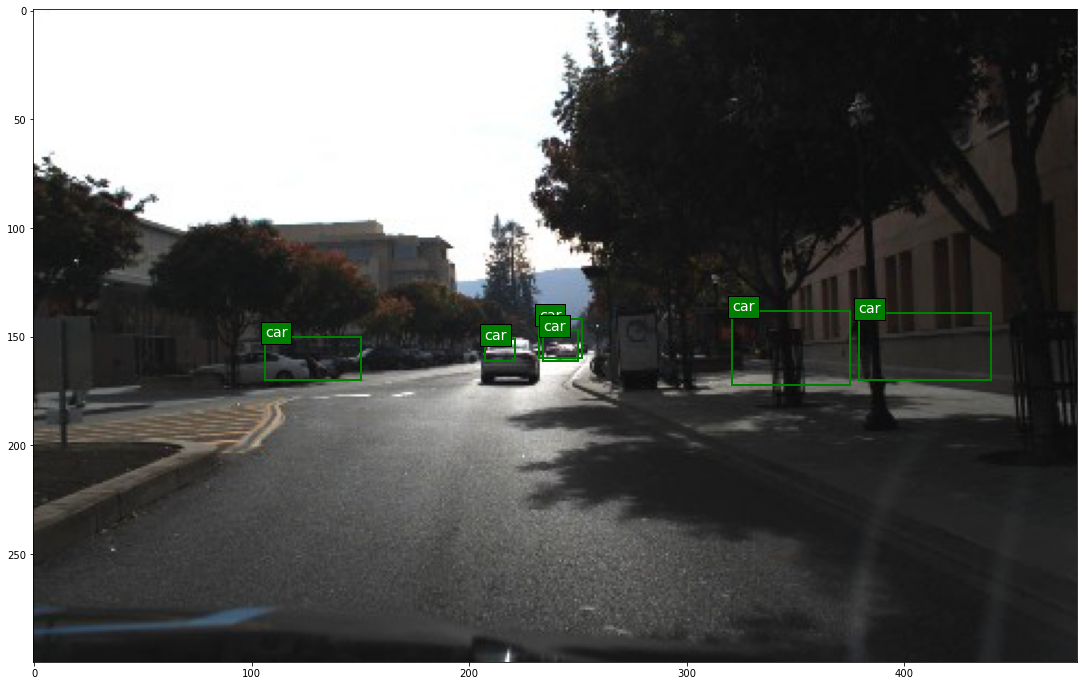

In [60]:
plt.figure(figsize=(20,12))
plt.imshow(batch_images[5])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  